<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jdecorte/ai_ml/blob/main/121-pretrained_word_embeddings_case_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>  

In [24]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D,  MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model


import nltk


2.8.0


In [25]:
# helper functions for visualisation
# plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [26]:
df_dataset = pd.read_csv("https://raw.githubusercontent.com/jdecorte/ai_ml/main/datasets/SMSSpamCollection.csv") 
df_dataset.columns
df_dataset.dtypes

label    object
text     object
dtype: object

In [27]:
# Take a look at the data
df_dataset.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
# Changing spam and ham into 0 and 1
df_dataset['label'] = np.where(df_dataset['label'] == "spam", 0, 1)
df_dataset.head()

,label,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [29]:
# Show the general information about the data
df_dataset.describe()

,label
count,5572.000000
mean,0.865937
std,0.340751
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


Remove stopwords

In [30]:
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string
    
def remove_stopwords_en(text):
    stop_words_en = set(stopwords.words('english')) 
    punctuations="?:!.,;<>/\+-"
    # turn the string into a list of words based on separators (blank, comma, etc.)
    word_tokens = word_tokenize(text.lower())
    # create a list of all words that are neither stopwords nor punctuations
    result = [x for x in word_tokens if x not in stop_words_en and x not in punctuations]
    
    # create a new string of all remaining words
    seperator = ' '
    return seperator.join(result)

df_dataset['text'] = df_dataset['text'].apply(remove_stopwords_en)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcor864\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# What is the average length of the SMS messages. This will be important when we need to truncate the sequences to a maximum length
df_dataset['numberOfWords'] = df_dataset.text.str.split().apply(len)
df_dataset.head()

,label,text,numberOfWords
0,1,go jurong point crazy .. available bugis n gre...,19
1,1,ok lar ... joking wif u oni ...,8
2,0,free entry 2 wkly comp win fa cup final tkts 2...,30
3,1,u dun say early hor ... u c already say ...,11
4,1,nah n't think goes usf lives around though,8


In [32]:
# Show the general information about the column numberOfWords
# Notice that 75% of the messages consists of only 23 words or less.
df_dataset['numberOfWords'].describe()

count    5572.000000
mean       10.537330
std         8.033644
min         0.000000
25%         5.000000
50%         8.000000
75%        15.000000
max       134.000000
Name: numberOfWords, dtype: float64

In [33]:
# Extract a training & validation split
from sklearn.model_selection import train_test_split
X = df_dataset.drop(['label','numberOfWords'],axis=1)
y = df_dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(type(X_train))

X_train shape: (3900, 1)
X_test shape: (1672, 1)
3900 train samples
1672 test samples
<class 'pandas.core.frame.DataFrame'>


For Keras we need to convert pandas dataframes to numpy arrays:

In [34]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

print('X_train shape:', X_train.shape)
print(type(X_train))

X_train shape: (3900, 1)
<class 'numpy.ndarray'>


In [35]:
# look at the new labels for the first sample
print(y_train[0])
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

1
y_train shape: (3900,)
y_test shape: (1672,)


### Create a vocabulary index

Let's use the TextVectorization to index the vocabulary found in the dataset. 

TextVectorization = 
- build vocabulary from complete text collection (= all sms's)
- assign to each word an index
- replace words in dataset by index
- limit each text to an maximum length
- pad shorter texts with ''

Deep Learning systems are often trained on very large datasets that will not fit in RAM. Ingesting a large dataset and preprocessing it efficiently can be tricky to implement with other Deep Learning libraries, but TensorFlow (on which Keras is based) makes it easy thanks to the Data API: you just create a **dataset** object, and tell it where to get the data and how to transform it. TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, and prefetching.

In [36]:
from tensorflow.keras.layers import TextVectorization

# max_tokens = integer parameter that will control the maximum size of the vocabulary. 
# We will only consider the top 20 000 words
# output_sequence_length = 25: we will truncate or pad sequences to be actually 25 tokens long.
# This is the reason why we calculated the number of words for each message in a previouse step
# From the describe we learn that 75% of the messages are not longer than 23 tokens
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=25)

# Make a Dataset from a numpy array
# A tf.data.Dataset represents a potentially large set of elements.
text_ds = tf.data.Dataset.from_tensor_slices(X_train)

# Call the adapt method to build the vocabulary
vectorizer.adapt(text_ds)


In [37]:
# You can retrieve the computed vocabulary used via vectorizer.get_vocabulary(). 
# Let's print the top 25 words:
vectorizer.get_vocabulary()[:25]

['',
 '[UNK]',
 'u',
 'call',
 's',
 '2',
 'nt',
 'ur',
 'm',
 'get',
 'gt',
 'lt',
 '4',
 'free',
 'ok',
 'go',
 'know',
 'good',
 'got',
 'like',
 'come',
 'll',
 'time',
 'love',
 'day']

- index 0 is reserved for the padding token
- index 1 is reserved for "out of vocabulary" tokens.

In [43]:
# Let's vectorize a test sentence, based on the vocabulary we created from the training dataset):
output = vectorizer([["i will call you next week"]])
print(type(output))
output.numpy()

<class 'tensorflow.python.framework.ops.EagerTensor'>


array([[826,   1,   3,   1, 137,  55,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)

"will" and "your" are missing because they have been removed during stopword removal.

Here's a dictionary mapping words of the vocabulary of the dataset to their indices in the :

In [44]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

As you can see, we obtain the same encoding as above for our test sentence:

In [46]:
test = ["i","will","call", "you", "next", "week"]
[word_index.get(w,'N/A') for w in test]

[826, 'N/A', 3, 'N/A', 137, 55]

### Load pre-trained word embeddings
Let's download pre-trained GloVe embeddings (a 822M zip file).
Rather than training our own word vectors from scratch, we will leverage on GloVe. Its authors have released four text files with word vectors trained on different massive web datasets.

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

glove.6B = Wikipedia 2014 + Gigaword 5. It was trained on a corpus of 6 billion tokens and contains a vocabulary of 400 000 tokens.

You'll need to run the following commands:

In [47]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print ('You are running on Google Colab')
else:
    colab = False
    print ('You are not running on Google Colab')

if colab:
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    from google.colab import drive
    drive.mount('/content/gdrive')
    !ls '/content'
    !unzip -q glove.6B.zip
    # After unzipping the downloaded file we find 4 txt files: glove.6B.50d.txt, glove.6B.100d.txt, glove.6B.200d.txt, glove.6B.300d.txt. 
    # As their filenames suggests, they have vectors with different dimensions.
    !ls '/content'
    # move glove.6B.100d.txt to My Drive so it will be available for use in the future
    !mv '/content/glove.6B.100d.txt' '/content/gdrive/My Drive/glove.6B.100d.txt'

# if your are working local you can download the file from http://nlp.stanford.edu/data/glove.6B.zip and unzip it in your datasets directory

You are not running on Google Colab


If we used glove.6B.50d.txt and we printed  the content of the file on console, we could see that each line contain as first element a word followed by 50 real numbers. For instance these are the first two lines, corresponding to tokens "the" and ",":

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581

, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [48]:
# we compute an index mapping words to known embeddings
# by parsing the data dump of pre-trained embeddings:

if colab: 
  path_to_glove_file = '/content/gdrive/My Drive/glove.6B.100d.txt'
else:
  path_to_glove_file = 'datasets/glove.6B.100d.txt'

embeddings_index = {}

with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:

      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index $i$ is the pre-trained vector for the word of index $i$ in our vectorizer's vocabulary. That means we are mapping words from the vocabulary of our dataset to their corresponding coordinates in the 100 dimensional geometric space from Glove. 

In [49]:
num_tokens = len(voc) # + 2
# each word is represented by a vector of 100 floats (glove.6B.100d.txt)
embedding_dim = 100
hits = 0
misses = 0
missed_words = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# word_index is a dictionary that maps each word to an index
# we loop through all the words of word_index.items()
# the items() method of a dictionary returns a list of tuples (key, index) for all elements in the dictionary
for word, i in word_index.items():
# we try to retrieve the vector of 100 floats for this word out of embeddings_index  
    embedding_vector = embeddings_index.get(word)
# if we found the corresponding vector of 100 floats    
    if embedding_vector is not None:
      # we put the vector on position i of embedding_matrix
        embedding_matrix[i] = embedding_vector
        hits += 1    
    else:
      # Words not found in embedding index will be all-zeros.    
        misses += 1
        missed_words.append(word)
        
print("Converted %d words (%d misses)" % (hits, misses))

print("*** shape of the embedding matrix:***")
print(embedding_matrix.shape)

print("*** Missed words = words not in word_index ***")
print(missed_words[0:10])
print()
print("*** i has which index in word_index? ***")
index_i = word_index['i']
print(index_i)
print()
print("*** the vector of 100 floats representing i ***")
print(embedding_matrix[index_i])
print()
print("*** cat has which index in word_index? ***")
index_cat = word_index['cat']
print(index_cat)
print()
print("*** the vector of 100 floats representing cat ***")
print(embedding_matrix[index_cat])

Converted 5400 words (2076 misses)
*** shape of the embedding matrix:***
(7478, 100)
*** Missed words = words not in word_index ***
['', '[UNK]', 'thanx', '£1000', '150ppm', 'aight', '150p', '£2000', '£150', '£100']

*** i has which index in word_index? ***
826

*** the vector of 100 floats representing i ***
[-0.046539    0.61966002  0.56647003 -0.46584001 -1.18900001  0.44599
  0.066035    0.31909999  0.14679    -0.22119001  0.79238999  0.29905
  0.16073     0.025324    0.18678001 -0.31000999 -0.28108001  0.60514998
 -1.0654      0.52476001  0.064152    1.03579998 -0.40779001 -0.38011
  0.30801001  0.59964001 -0.26991001 -0.76034999  0.94221997 -0.46919
 -0.18278     0.90652001  0.79671001  0.24824999  0.25713     0.6232
 -0.44768     0.65357     0.76902002 -0.51229    -0.44332999 -0.21867
  0.38370001 -1.14830005 -0.94397998 -0.15062     0.30012    -0.57805997
  0.20175    -1.65910006 -0.079195    0.026423    0.22051001  0.99713999
 -0.57538998 -2.72659993  0.31448001  0.70521998  1

In [50]:
X_train[:5]

array([['thanks picking trash'],
       ['ok tell stay yeah tough optimistic things improve month'],
       ["tell quite long cos n't finish film yet ..."],
       ['speaking cash yet'],
       ['ok ...']], dtype=object)

In [51]:
np.array([s for s in X_train])[:5]

array([['thanks picking trash'],
       ['ok tell stay yeah tough optimistic things improve month'],
       ["tell quite long cos n't finish film yet ..."],
       ['speaking cash yet'],
       ['ok ...']], dtype=object)

### Prepare the data
First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

In [52]:
X_train_final = vectorizer(np.array([s for s in X_train])).numpy()
X_test_final = vectorizer(np.array([s for s in X_test])).numpy()

y_train_final = np.array(y_train)
y_test_final = np.array(y_test)

print(X_train_final[:5])
print(X_train.shape)
print(X_test.shape)
print(X_train_final.shape)
print(X_test_final.shape)
print('----------------')
print(y_train_final)
print(y_train_final.shape)
print(y_test_final.shape)

[[ 111  905 3777    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  14   53  365   83 1148 4838  174 5531  261    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  53  273  192  106    6  203 1088  144    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [2376  125  144    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  14    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
(3900, 1)
(1672, 1)
(3900, 25)
(1672, 25)
----------------
[1 1 1 ... 1 1 1]
(3900,)
(1672,)


### Build the model
- Keras provides many preprocessing layers. We have seen earlier the `Flatten()` layer as an example.  
- Another exampel is the `Embedding()` layer.  
- It turns positive integers (indexes) into dense vectors of fixed size.  
        e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
- We use it to load the pre-trained word embeddings matrix into an Embedding layer.
- All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, so it will map for each sms message the index of each word to the coordinates in the geometry.
- The `keras.layers.Embedding` layer handles an embedding matrix, which is trainable by default. 
- We need to set `trainable=False` so as to keep the embeddings fixed (we don't want to update them during training because we use pretrained word embeddings).

In [53]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
num_tokens

7478

In [55]:
num_classes = 2

def initial_model():
    # we create a variable called model, and we set it equal to an instance of a Sequential object.
    model = Sequential()

    model.add(Embedding(input_dim=num_tokens, output_dim=embedding_dim, input_length=25,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False))
    model.add(keras.layers.Flatten(input_shape=[num_tokens, embedding_dim]))

    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(Dense(num_classes, activation='softmax'))


    # Before we can train our model, we must compile it
    # To the compile() function, we are passing the optimizer, the loss function, and the metrics that we would like to see. 
    # Notice that the optimizer we have specified is called Adam. Adam is just a variant of SGD. 
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01),
                  metrics=['accuracy']) 
    return model


In [56]:
model_1 = initial_model()
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           747800    
                                                                 
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 100)               250100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               1

### Train the model

In [57]:
# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 64
epochs = 20

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)



history_1 = model_1.fit(X_train_final, y_train_final,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_final, y_test_final),
                    callbacks=[early_stopping_cb]
                    )


Epoch 1/20
61/61 [==============================] - 1s 11ms/step - loss: 0.5409 - accuracy: 0.8723 - val_loss: 0.1559 - val_accuracy: 0.9402
Epoch 2/20
61/61 [==============================] - 1s 9ms/step - loss: 0.1596 - accuracy: 0.9464 - val_loss: 0.1055 - val_accuracy: 0.9671
Epoch 3/20
61/61 [==============================] - 1s 8ms/step - loss: 0.1156 - accuracy: 0.9631 - val_loss: 0.1578 - val_accuracy: 0.9671
Epoch 4/20
61/61 [==============================] - 1s 9ms/step - loss: 0.1022 - accuracy: 0.9713 - val_loss: 0.1233 - val_accuracy: 0.9599


### Evaluate the model

Training set Accuracy:   0.98
Training set Loss: 0.0611

Validation set Accuracy:   0.97
Validation set Loss: 0.1055



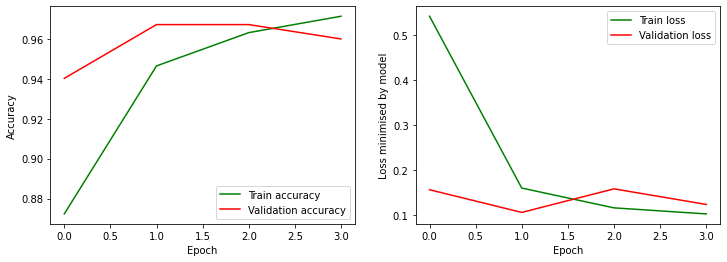

In [58]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(X_train_final, y_train_final, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(X_test_final, y_test_final, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

### Use the model

In [59]:
X_example = vectorizer(np.array([s for s in ["URGENT! Your Mobile No. was awarded a €2000 Bonus Caller Prize"]])).numpy()
pred = model_1.predict([X_example])
print(pred)

[[0.996434   0.00356604]]


In [60]:
X_example = vectorizer(np.array([s for s in ["Please call me"]])).numpy()
pred = model_1.predict([X_example])
print(pred)

[[7.1091263e-06 9.9999285e-01]]
